In [1]:
from MetaWorld.utilsMW.trainer import ActiveCritic, ActiveCriticArgs
from stable_baselines3.common.torch_layers import CombinedExtractor
from MetaWorld.utilsMW.model_setup_obj import NetworkSetup
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
from MetaWorld.searchTest.utils import MyEnv, ToyExpertModel, sample_expert_transitions, benchmark_policy, LearnWrapper, train_policy, LearnWrapper, parse_sampled_transitions, VecExtractor
import torch
import zipfile
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
import importlib
import numpy as np
from RlBaselines3Zoo import enjoy
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.ppo import MlpPolicy

from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper

from stable_baselines3.common.policies import MultiInputActorCriticPolicy, ActorCriticPolicy, BaseModel
from stable_baselines3.common.torch_layers import (
    BaseFeaturesExtractor,
    CombinedExtractor,
    FlattenExtractor,
    NatureCNN,
    create_mlp,
    get_actor_critic_arch,
)
from sb3_contrib.tqc.tqc import TQC
from sb3_contrib.tqc.policies import MultiInputPolicy
import numpy as np
import torch as th
import os

from MetaWorld.searchTest.utils import train_policy

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

model = enjoy.main(inpt_args="--algo tqc --env FetchPickAndPlace-v1 --folder /home/hendrik/Documents/master_project/Code/RlBaselines3Zoo/rl-trained-agents -n 300 --ret_model True")
def sample_expert_transitions():
    expert = model

    print("Sampling expert transitions.")
    rollouts = rollout.rollout(
        expert,
        DummyVecEnv([lambda: RolloutInfoWrapper(model.env.envs[0])]),
        rollout.make_sample_until(min_timesteps=None, min_episodes=100),
        unwrap=True,
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts)

tp = '/home/hendrik/Documents/master_project/LokalData/ImitationLearning/transitions_rew_100'

#transitions = sample_expert_transitions()
#torch.save(transitions, tp)
transitions = torch.load('/home/hendrik/Documents/master_project/LokalData/ImitationLearning/transitions_rew_100')



/home/hendrik/anaconda3/envs/tfTest/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-08-17 19:03:29.926789: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-17 19:03:31.711071: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-17 19:03:31.711148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-17 19:03:31.711232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 19:03:31.711357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Fou

1 Physical GPUs, 1 Logical GPUs
Loading latest experiment, id=1
Loading /home/hendrik/Documents/master_project/Code/RlBaselines3Zoo/rl-trained-agents/tqc/FetchPickAndPlace-v1_1/FetchPickAndPlace-v1.zip


In [2]:
from MetaWorld.metaworld.policies.sawyer_pick_place_v2_policy import SawyerPickPlaceV2Policy
from metaworld.envs import ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE
from MetaWorld.utilsMW.makeTrainingData import make_policy_dict
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from typing import Union, Type, Optional
from gym.wrappers import TimeLimit

from stable_baselines3.common.type_aliases import GymEnv
policy_dict = make_policy_dict()
gt_policy = policy_dict['pickplace']
pape = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[policy_dict['pickplace'][1]]()
pape._freeze_rand_vec = False
timelimit = TimeLimit(env=pape, max_episode_steps=100)
dv1 = DummyVecEnv([lambda: RolloutInfoWrapper(timelimit)])
class ImitationLearningWrapper:
    def __init__(self, policy, env:GymEnv):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.policy = policy

    def predict(self, obsv, deterministic=None):
        actions = []
        for obs in obsv:
            actions.append(self.policy.get_action(obs))
        return actions
IGTP = ImitationLearningWrapper(policy=gt_policy[0], env=dv1).predict

def new_epoch(current_obs, check_obsvs):
    result =  not th.equal(current_obs.reshape(-1)[-3:], check_obsvs.reshape(-1)[-3:])
    return result
    
class DummyExtractor:
    def __init__(self):
        pass
    def forward(self, features):
        if type(features) is np.ndarray:
            features = th.tensor(features)
        return features

def sample_expert_transitions(expert):
    print("Sampling expert transitions.")
    rollouts = rollout.rollout(
        expert,
        dv1,
        rollout.make_sample_until(min_timesteps=None, min_episodes=25),
        unwrap=True,
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts)
transitions = sample_expert_transitions(IGTP)

Sampling expert transitions.


/home/hendrik/Documents/master_project/Code/MetaWorld/metaworld/policies/policy.py:41: UserWarning: Constant(s) may be too high. Environments clip response to [-1, 1]
  warnings.warn('Constant(s) may be too high. Environments clip response to [-1, 1]')


In [3]:
#transitions = th.load('tmp/imitation/transitions')

train self.data: torch.Size([25, 100, 39])
train self.label: torch.Size([25, 100, 4])
len(train_data): 25
train self.data: torch.Size([25, 100, 39])
train self.label: torch.Size([25, 100, 4])
log dir: /home/hendrik/Documents/master_project/LokalData/gboard/GT pickplace V2 25 continue/train/


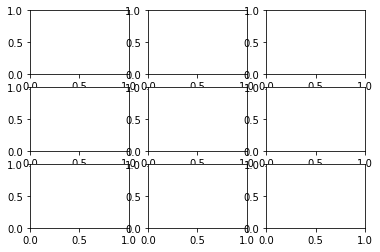

In [4]:
args_obj = ActiveCriticArgs()
args_obj.set_batchsize(32)
args_obj.set_data_path(path='/home/hendrik/Documents/master_project/LokalData/')
args_obj.set_device(device='cuda')
args_obj.set_feature_extractor(DummyExtractor())
args_obj.set_log_name('GT pickplace V2 25 continue')
args_obj.set_meta_optimizer_lr(1e-2)
args_obj.set_mlr(5e-5)
args_obj.set_network_setup(NetworkSetup())
args_obj.set_tboard(True)
args_obj.set_demonstrations(demonstrations=transitions)
args_obj.set_val_every(interval=1000)
args_obj.set_epoch_len(epoch_len=100)
args_obj.set_imitation_phase(False)
args_obj.set_weight_decay(1e-2)
args_obj.set_new_epoch(new_epoch=new_epoch)
args_obj.set_eval_epochs(epochs=100)
args_obj.set_opt_steps(20)
args_obj.set_complete_modulo(20)

ac = ActiveCritic(
    policy=None,
    env=dv1,
    args_obj=args_obj,
    learning_rate=5e-5,
    extractor=DummyExtractor()
)

In [5]:
ac.network.loadNetworkFromFile(path='/home/hendrik/Documents/master_project/LokalData/Data/Model/GT pickplace V2 25/last/')

log dir: /home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/gboard/GT pick place V2 imitation 25 continue/train/
Sampling expert transitions. 1
in trainer reward: 0.0
torch.Size([1, 100, 4])
inital num examples: 25
Sampling expert transitions. 1
inpt_obs_opt: torch.Size([1, 100, 39])
trajectories_opt: torch.Size([1, 100, 4])
success_opt: tensor([1.], device='cuda:0')
ftrjs_opt: torch.Size([1, 100, 4])
episodes: 1
train self.data: torch.Size([26, 100, 39])
train self.label: torch.Size([26, 100, 4])
num examples: 26
num demonstrations: 26
logname: GT pickplace V2 25 continue
Running full validation...
Sampling expert transitions. 100


KeyboardInterrupt: 

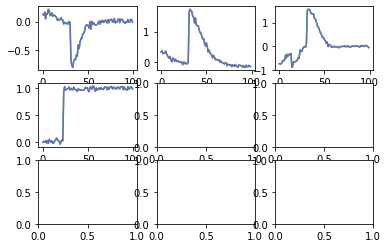

In [6]:
train_policy(trainer=ac, 
learn_fct=ac.learn, 
val_env=ac.env, 
logname='GT pick place V2 imitation 25 continue', 
path='/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/',
n_epochs=1000,
n_steps=1,
eval_epochs=1,
step_fct=lambda i:i+1,
new_epoch=new_epoch,
extractor=DummyExtractor()
)

In [ ]:
a, b, c = ac.network.sample_new_episode(policy=ac.policy, env=dv1, episodes=5, add_data=False)

Sampling expert transitions. 5
:::::
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


log dir: /home/hendrik/Documents/master_project/LokalData/Data/Model/GT pickplace V2 25/gboard/reload test/train/
Sampling expert transitions. 20
in trainer reward: 0.0
torch.Size([20, 100, 4])


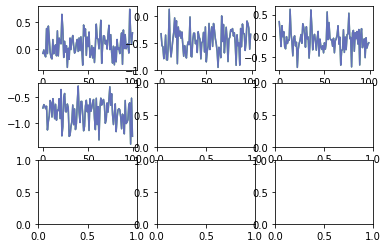

In [ ]:
r, t = benchmark_policy(
    policy=ac.policy, 
    path='/home/hendrik/Documents/master_project/LokalData/Data/Model/GT pickplace V2 25/',
    logname='reload test',
    eval_epochs=20,
    val_env=dv1,
    stepid=1,
    best_reward= -10,
    new_epoch=new_epoch,
    extractor=DummyExtractor(),
    save_model=False
    )

In [ ]:
trans = sample_expert_transitions(ac.policy)

Sampling expert transitions.


In [ ]:
a,b,c = parse_sampled_transitions(transitions=trans, new_epoch=new_epoch, extractor=DummyExtractor())

In [ ]:
print(b.shape)

torch.Size([2, 100, 39])


In [ ]:
print(c.shape)

torch.Size([9])


In [ ]:
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[400, 300]))
# Create the agent
model = SAC("MlpPolicy", timelimit, verbose=1, policy_kwargs=policy_kwargs)
model.device

In [ ]:
bc_policy = ActorCriticPolicy(observation_space=timelimit.observation_space, action_space=timelimit.action_space, lr_schedule=lambda a:1, net_arch=[512,512,512])

In [ ]:
env = dv1
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    policy=bc_policy,
    device='cuda'
)

In [ ]:
train_policy(
    trainer=bc_trainer,
    learn_fct=bc_trainer.train,
    val_env=dv1,
    logname='GT 10 V2 ActorCritic',
    path='/home/hendrik/Documents/master_project/LokalData/ImitationLearning/',
    n_epochs=1000,
    n_steps=50,
    eval_epochs=100,
    step_fct=lambda i: i+1,
    new_epoch=new_epoch,
    extractor=DummyExtractor()
)

In [ ]:
benchmark_policy(
    bc_policy, 
    path='/home/hendrik/Documents/master_project/LokalData/ImitationLearning/',
    logname='BC test gt pick place V2',
    eval_epochs=300,
    val_env=dv1,
    stepid=1,
    best_reward=-1,
    new_epoch=new_epoch,
    extractor=DummyExtractor(),
    save_model=False,
    )

In [ ]:
#ac.policy.load_state_dict(torch.load('/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/First integrated test/best_modeltensor(-0.9200)'))

In [ ]:
train_policy(trainer=ac, 
learn_fct=ac.learn, 
val_env=ac.env, 
logname='GT pick place V2', 
path='/home/hendrik/Documents/master_project/LokalData/TransformerImitationLearning/',
n_epochs=1000,
n_steps=1,
eval_epochs=1,
step_fct=lambda i:i+1,
new_epoch=new_epoch,
extractor=DummyExtractor()
)

In [ ]:
ac.learn(n_epochs=1)

In [ ]:
ac.network.runValidation(quick=False, pnt=True, epoch=1, save=False, complete=True)